# Mobile Electronics SDA

### Loading and pre-processing

In [1]:
import pandas as pd
from bs4 import BeautifulSoup
import demoji
import re
import nltk
import contractions
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

#Download data to perform future tasks
nltk.download('wordnet')
demoji.download_codes()

#Create NLTK lemmatizer
lemmatizer = WordNetLemmatizer()

#Store stop words
stop_words = stopwords.words('english')


#URL for mobile electronic Amazon reviews
url = 'https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Mobile_Electronics_v1_00.tsv.gz'

#Data acquisition
df = pd.read_csv(url, sep='\t', error_bad_lines=False)

#Removing nulls
df = df.dropna()

#Making sure review date is a datetime
df['review_date'] = pd.to_datetime(df['review_date'])

#Removes html tags and handles special characters
def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    new_text = soup.get_text(separator=" ")
    return new_text

#Turns emojis into text
def process_emojis(text):
    #Detect any emojis in text string
    found_emojis = demoji.findall(text)
    if found_emojis:
        #Loop through each emoji found
        for key, value in found_emojis.items():
            #replace with emoji text.. add spaces to account for emoji's right next to each other
            text = (text.replace(key, ' ' + value[:value.find(':') if ':' in value else len(value)] + ' ')
                    .replace('🏽', ''))
        #using regex to find double spaces and replace with single space, then return new text string
        return re.sub(' +', ' ', text)
    return text

#Lowercases text
def lowercase_text(text):
    return text.lower()

#Removes extra whitespace
def remove_whitespace(text):
    return re.sub(' +', ' ', text.strip())

#Fixes contractions
def fix_contractions(text):
    return contractions.fix(text)

#Tokenizes text data
def tokenize(text):
    return nltk.word_tokenize(text)

#Removes common stop words
def remove_stop_words(tokens):
    return [i for i in tokens if i not in stop_words]

#Lemmatizes text data
def lemmatize(tokens):
    return [lemmatizer.lemmatize(i) for i in tokens]

#Performs each of the text processing functions above and returns a list of tokenized text data
def process_text(text):
    text = strip_html_tags(text)
    text = fix_contractions(text)
    text = remove_whitespace(text)
    text = process_emojis(text)
    text = lowercase_text(text)
    tokens = tokenize(text)
    tokens = remove_stop_words(tokens)
    tokens = lemmatize(tokens)
    return tokens

df['processed_text'] = [process_text(i) for i in df['review_body'].values.tolist()]

[nltk_data] Downloading package wordnet to /Users/kmf229/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


... OK (Got response in 0.16 seconds)
Writing emoji data to /Users/kmf229/.demoji/codes.json ...
... OK


b'Skipping line 35246: expected 15 fields, saw 22\n'
b'Skipping line 87073: expected 15 fields, saw 22\n'


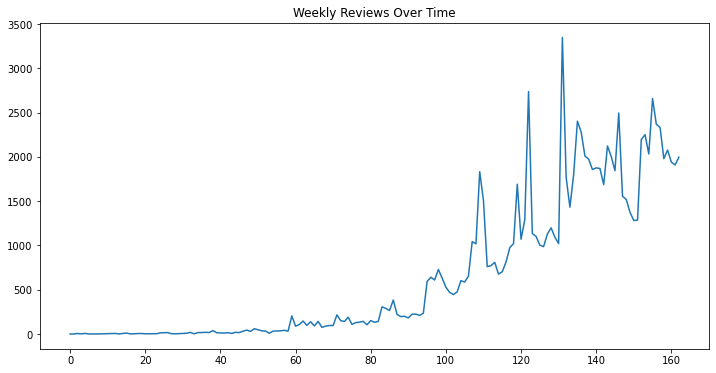

In [2]:
df['review_month'] = df['review_date'].dt.month
df['review_year'] = df['review_date'].dt.year
df['month'] = df['review_year'].astype(str) + '-' + df['review_month'].astype(str)
ratings = df[['star_rating', 'product_id', 'month']].groupby('month', as_index=False).agg({
    'star_rating': 'mean', 'product_id': 'count'
}).reset_index(drop=True).rename(columns={'product_id':'num_reviews'})



fig = plt.figure(figsize=(12,6))
plt.plot(ratings['num_reviews'])
plt.title("Weekly Reviews Over Time")
plt.show()

Text(0.5, 1.0, 'Reviews/Day Growth Over The Years')

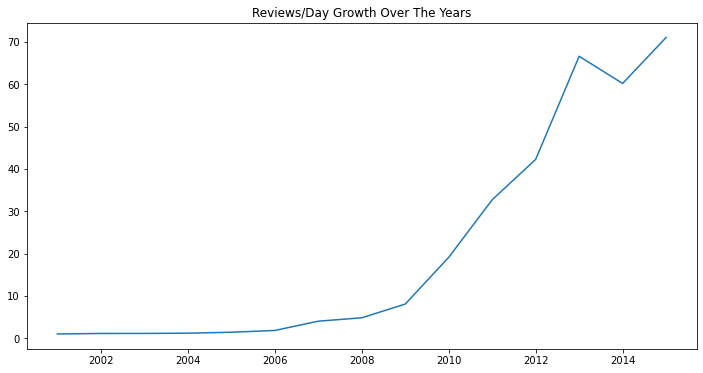

In [3]:
perday = df[['review_date', 'product_id']].groupby('review_date', as_index=False).count().rename(columns={'product_id':'reviews/day'})
perday['year'] = perday['review_date'].dt.year
yearly = perday.groupby('year', as_index=False).mean()
fig = plt.figure(figsize=(12,6))
plt.plot(yearly['year'], yearly['reviews/day'])
plt.title("Reviews/Day Growth Over The Years")

In [4]:
yearly

,year,reviews/day
0,2001,1.000000
1,2002,1.120000
2,2003,1.129630
3,2004,1.185567
4,2005,1.408805
5,2006,1.830579
6,2007,4.020408
7,2008,4.820937
8,2009,8.063014
9,2010,19.104110


Text(0.5, 1.0, 'Review Seasonality - Reviews Per Day By Month')

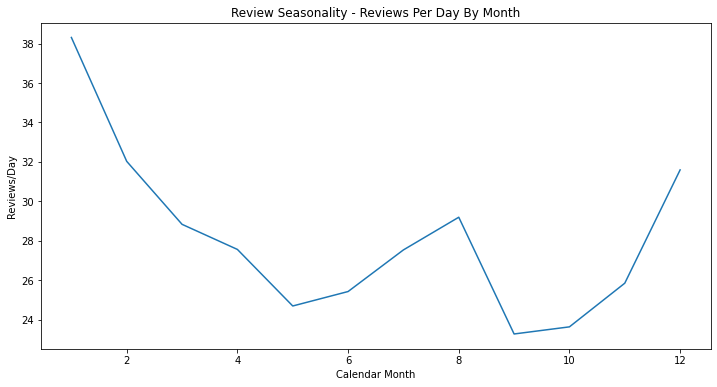

In [119]:
perday = df[['review_date', 'product_id']].groupby('review_date', as_index=False).count().rename(columns={'product_id':'reviews/day'})
perday['month'] = perday['review_date'].dt.month
monthly = perday.groupby('month', as_index=False).mean()
fig = plt.figure(figsize=(12,6))
plt.plot(monthly['month'], monthly['reviews/day'])
plt.ylabel("Reviews/Day")
plt.xlabel("Calendar Month")
plt.title("Review Seasonality - Reviews Per Day By Month")

In [21]:
df[['star_rating', 'product_id', 'review_month']].groupby('review_month', as_index=False).agg({
    'star_rating': 'mean', 'product_id': 'count'
}).reset_index(drop=True).rename(columns={'product_id':'num_reviews', 'star_rating': 'avg_star_rating'})

,review_month,avg_star_rating,num_reviews
0,1,3.797406,12261
1,2,3.746151,9352
2,3,3.786148,9053
3,4,3.770797,8102
4,5,3.729872,7974
5,6,3.759007,7855
6,7,3.778252,9141
7,8,3.808144,9283
8,9,3.759599,6980
9,10,3.758999,7112


In [55]:
df['review_date'].max()

Timestamp('2015-08-31 00:00:00')

In [70]:
test = df[['product_id', 'review_date']]
test['last_date'] = test['review_date']
prod_age = test.groupby('product_id', as_index=False).agg({'review_date': 'min', 'last_date': 'max'})
max_date = df['review_date'].max()
prod_age['age'] = (max_date - prod_age['review_date']).dt.days
prod_age = prod_age[['product_id', 'age']].set_index('product_id')
prod_age = prod_age.to_dict()['age']

product_reviews = df[['product_id', 'review_id', 'star_rating']].groupby('product_id', as_index=False).agg({'review_id': 'count', 'star_rating': 'mean'}).rename(columns={'review_id': 'reviews'})
product_reviews['avg_age'] = product_reviews['product_id'].map(prod_age)
bins = [.999, 1.999, 2.999, 10.999, 2000]
labels = ['1', '2', '3 - 10', '10+']
product_reviews['review_count_bucket'] = pd.cut(product_reviews['reviews'], labels=labels, bins=bins, duplicates='drop')
product_reviews.groupby('review_count_bucket').agg({'product_id': 'count', 'avg_age': 'mean', 'star_rating': 'mean'}).rename(columns={'product_id': 'num_products', 'star_rating': 'avg_star_rating'})


,num_products,avg_age,avg_star_rating
review_count_bucket,,,
1,15052,931.685158,3.626428
2,4146,1126.129764,3.688495
3 - 10,5040,1261.847817,3.732429
10+,1547,1330.376858,3.810405


In [116]:
df['review_body_length'] = df['review_body'].str.len()
(df[['star_rating', 'product_id', 'review_body_length']]
 .groupby('star_rating')
 .agg({'product_id': 'count', 'review_body_length': 'mean'})
 .rename(columns={'product_id': 'num_reviews', 'review_body_length': 'avg_review_length'}))

,num_reviews,avg_review_length
star_rating,,
1.0,17571,329.335439
2.0,7298,386.772403
3.0,9719,409.118016
4.0,18063,413.273653
5.0,52196,303.626025


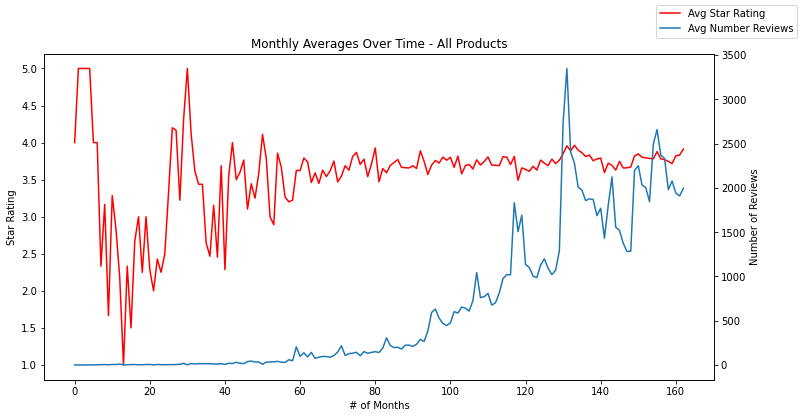

In [20]:
stars = (df[['star_rating', 'review_month', 'review_year', 'product_id']]
 .groupby(['review_year', 'review_month'], as_index=False)
 .agg({'star_rating': 'mean', 'product_id': 'count'})
 .rename(columns={'product_id': 'num_reviews'})
 .sort_values(['review_year', 'review_month']))
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(stars['star_rating'], color='red', label='Avg Star Rating')
plt.ylabel("Star Rating")
plt.xlabel("# of Months")
ax2 = ax1.twinx()
ax2.plot(stars['num_reviews'], label='Avg Number Reviews')
plt.title("Monthly Averages Over Time - All Products")
ax2.set_ylabel("Number of Reviews")
fig.legend()
plt.show()

In [84]:
cust = df.groupby('customer_id').agg({'product_id': 'count', 'star_rating': 'mean'}).rename(columns={'product_id': 'num_reviews', 'star_rating': 'avg_star_rating'})
cust[cust['num_reviews'] > 1].sort_values('num_reviews', ascending=False).head(10)

,num_reviews,avg_star_rating
customer_id,,
15127646,25,5.000000
29514513,21,3.000000
12259799,18,5.000000
34408569,10,1.000000
43856165,10,4.200000
19803990,10,5.000000
52460215,10,4.900000
49675502,9,5.000000
53037408,9,4.888889


(array([19370., 51058.,  9662.]),
 array([  1, 100, 300, 400]),
 <a list of 3 Patch objects>)

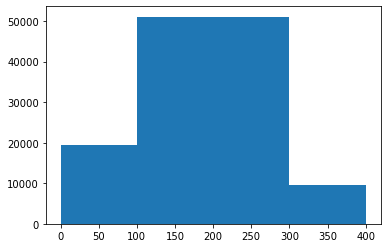

In [100]:
plt.hist(df['review_body_length'], bins=[1, 100, 300, 400])

In [115]:
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

df['review_body_length'].iplot(kind='hist',
    bins=100,
    xTitle='review length',
    linecolor='black',
    yTitle='count',
    title='Review Text Length Distribution')